# CS 224, Fall 2021
## Problem Set 1

## **DUE SUNDAY, October 24, 2021 @ 11:59pm PDT **


<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Your Name Here  <br>
    <b>Student ID Number:</b> Your SIN Here
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: 11.5/15<br>
    Late Days Used on this Assignment: 1<br>
    Total Late Days Used: 1<br>
    Total Late Days Remaining: 3<br>
</div>

### Preliminaries

We will be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below loads the data (much as done in class) and removes a few problematic rows and columns before converting it into a `numpy` matrix, `X`.  **Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

For ordinal or numeric values, they are kept as in the original data.  Categorical values are converted to consecutive integers, starting with 0.  When complete, the following variables have been added to the workspace:
 - `X`: the data, of shape (number of homes, number of features).  The last feature is the one of interest for prediction: the sale price
 - `featurenames`: an array (of strings) of each of the features'/columns' names
 - `iscat`: an array (of length `nfeat`) of booleans; True indicates the feature is categorical.
 - `categorynames`: an array of arrays of strings.  `categorynames[j][k]` is the name of the kth category for the jth feature/column (assuming that `iscat[j]` is True, otherwise `categorynames[j]` should be ignored).
 - `numcat`: an array of ints.  `numcat[j]` is the number of categories (same as `len(categorynames[j])`) for feature/column j
 - `nfeat`: total number of features/columns (including the value to be predicted -- the last feature)
 - `ncat`: number of categorical features/columns
 - `nreal`: number of numeric features/columns

In [127]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # this and above will make the figures large enough to read
def loadamesdata():
    import pandas as pd
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])

    categorynames = []
    iscat = []
    for col in dataframe:
        if dataframe[col].dtype.name == 'object' or col == 'MS SubClass':  # MS SubClass is misinterpreteed as numeric
            dataframe[col] = dataframe[col].astype('category')
            if (dataframe[col].cat.codes<0).any(): # these are -1s to indicate that the value is blank
                categorynames.append(['(blank)']+dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes+1
            else:
                categorynames.append(dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes
            iscat.append(True)
        else:
            categorynames.append(None)
            iscat.append(False)
            
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed

    return dataframe.to_numpy(), categorynames, iscat, dataframe.columns

(X,categorynames,iscat,featurenames) = loadamesdata()
nfeat = len(iscat)
ncat = sum(iscat[:-1])
nreal = len(iscat)-1-ncat
numcat = (X.max(axis=0)+1).astype(int)    

In [128]:
# Here are some helper plotting functions you may find useful

# creates a (roughly square) grid of axes that can hold at least n subplots
# returns a flattened (1D) list of these n axes
def getsubplots(n):
    plotrows = int(np.floor(np.sqrt(n)))
    plotcols = int(np.ceil(n/plotrows))

    fig,axs = plt.subplots(plotrows,plotcols)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    axs = axs.flatten()
    for ax in axs[n:]:
        ax.set_axis_off()
    return axs[:n]

# plots a line for the equation y = ax+b for the current axes' limits
def plotline(ax,a,b,clr='blue'):
    xends = np.array(ax.get_xlim())
    yends = xends*a+b
    ret = ax.plot(xends,yends,'-',color=clr)
    ax.set_xlim(xends)
    return ret


### Question 1
### 5 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 5/5<br>
</div>

For most of this problem set, we will just be considering one feature/column and seeing how that compares to the SalePrice (last column).  

First, consider only the **categorical** features.  Let $x$ be the value of this (single) feature and $y$ be the corresponding SalePrice value.  Let $K$ be the number of categories $x$ has.  We will model the dependence of $y$ on $x$ as a normal distribution whose mean (but not variance) depends on the value of $x$, with one separate mean parameter for each category of $x$.  Let $\mu_k$ be the mean parameter for when $x$ takes value $k$ and $\sigma^2$ be the variance for a total of $K+1$ parameters:

\begin{equation}
p(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y-\mu_x)^2}
\end{equation}

You should convince yourself that the maximum likelihood estimate for $\mu_1, \mu_2, \dots, \mu_K$ and $\sigma^2$ is
\begin{align*}
\hat{\mu}_j &= \frac{\sum_{i | x_i = j} y_i}{\sum_{i | x_i = j} 1} & \forall j \in \{1, 2, \dots, K\}\\
\hat{\sigma}^2 &= \frac{1}{m}\sum_{i=1}^m (y_i - \hat{\mu}_{x_i})^2
\end{align*}
That is, the maximum likelihood estimate for $\mu_j$ is the average of all of the $y$ values when $x=j$,
and the maximum likelihood estimate for the variance is the empirical average squared difference between these
means (predictions) and the true values.

Note that the estimate for $\sigma^2$ is the average squared error (difference between the prediction made by the mean and the true value) across the entire dataset.  Therefore, it gives a good way of deciding which features give better predictions for $y$.

**TO DO:**

Write code to calculate the MLE parameter estimates for each possible categorical feature.

Make a single figure with one subplot for each of the categorical features.    You may find the `getsubplots` function above helpful.


For each categorical feature, plot a scatter plot of the SalePrice versus the feature (in black) with the means (predictions) plotted in blue.  Order them from lowest $\sigma^2$ estimate (first) to highest (last).
As an example, for the "Exter Cond" feature, your subplot should look like

<img src="extencondexample.png">

A few hints:
 - You may want to call plt.gcf().tight_layout() after plotting all plots to get rid of the overlap
 - You don't need to put the y-labels and y-tick marks on all of the scatter plots (as they all have the same range).  This will help them fit together better.
 - You may want to set the subplot title to a smaller font: `ax.set_title(..., fontsize=8)` (for instance)
 - You may want to similarly reduce the size of the category names: `ax.set_xticklabels(...,fonsize=6)` (for instance)

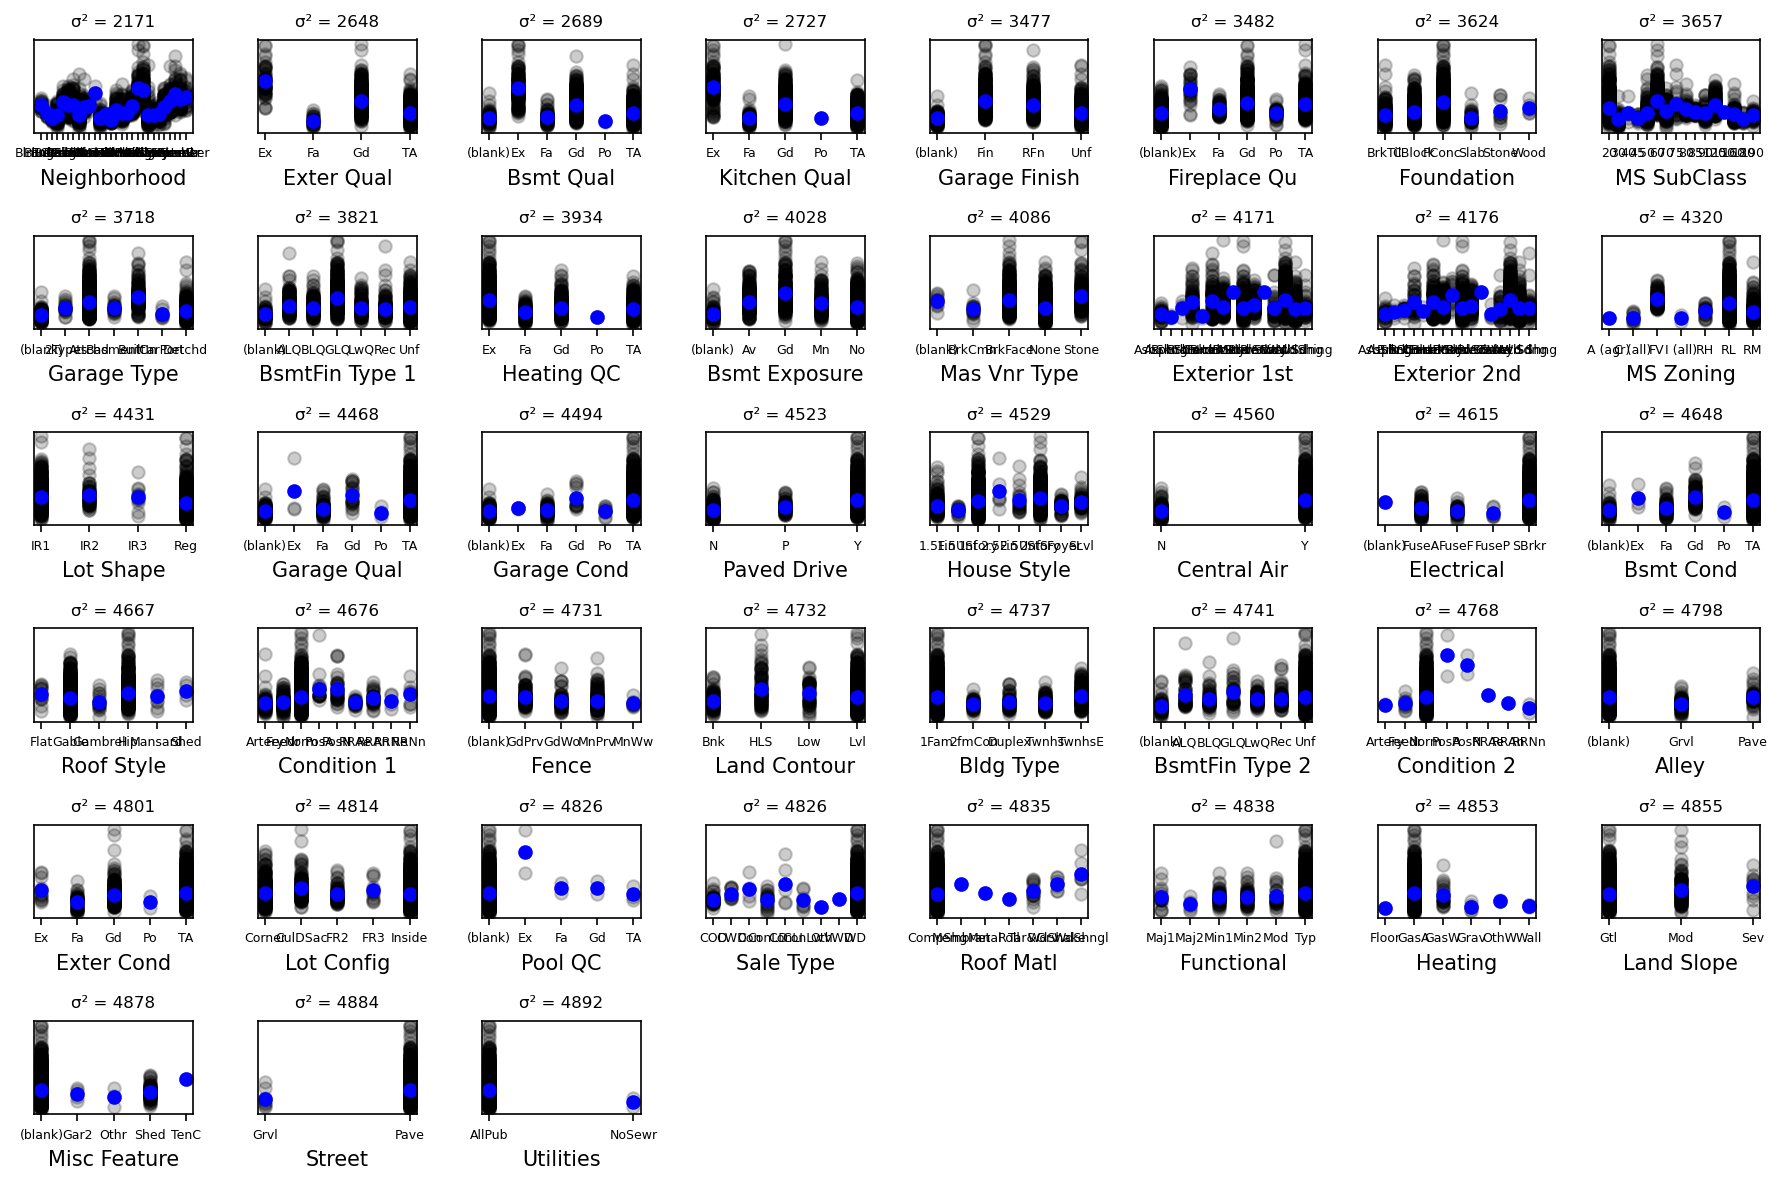

In [129]:
# YOUR ANSWER (CODE) HERE
salesprices = X[:,-1]
count = 0
j = 0
subplots = getsubplots(iscat.count(True))
feature_variance = []
feature_variance_map = {}
all_means_map = {}

for j in range(nfeat):
    if iscat[j] == True:
        col = X[:,j]
        total_variance = 0

        total = [0] * len(categorynames[j])
        kcount = [0] * len(categorynames[j])
        mean = []
        for row in range(len(col)):
            kcount[int(col[row])] = kcount[int(col[row])] + 1
            total[int(col[row])] = total[int(col[row])] + salesprices[row]

        for i in range(len(total)):
            mean.append(total[i]/kcount[i])
        
        for row in range(len(col)):
            total_variance = total_variance + pow((salesprices[row] - mean[int(col[row])]),2)
        final_variance = total_variance/(len(col))
        all_means_map[j] = mean
        feature_variance.append(final_variance)
        feature_variance_map[final_variance] = j
        count = count + 1

count = 0
feature_variance_map = dict(sorted(feature_variance_map.items()))
for variance in feature_variance_map.keys():
    j = feature_variance_map[variance]
    col = X[:,j]
    mean = all_means_map[j]
    subplots[count].scatter(col,salesprices, color = 'black', alpha=0.2)
    subplots[count].set_xlabel(featurenames[j])
    subplots[count].set_xticks(np.arange(len(categorynames[j])))
    subplots[count].set_xticklabels(categorynames[j], fontsize=6)
    subplots[count].set_title("σ² = " + str(int(variance)),  fontsize=8)
    subplots[count].scatter(list(range(len(mean))),mean, color = 'blue')
    subplots[count].yaxis.set_visible(False)
    count = count + 1
plt.gcf().tight_layout()

### Question 2
### 5 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 4/5<br>
</div>

Comments <br>
Plots not in order of increasing variance <br>

Now, let's do the same thing, but with the continuous-valued features.  In this case, we will model the distribution of the price, $y$, as a normal distribution whose mean is a linear function of the feature, $x$:

\begin{equation}
p(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y - (ax+b))^2}
\end{equation}

Therefore, our parameters are $a$, $b$, and $\sigma^2$.

This is "regular" linear regression and we can use the same equations to fit the data as from the class.

**TO DO**:

Again, make a single figure with a subplots, this time for each continuous-valued feature.

In each subplot, plot a scatter plot of the price versus the feature value, but this time for the continuous-valued features.  On each subplot, in blue plot the regression line ($y = ax+b$).  Again, title the plots by the variance of the estimator and sort from lowest variance (best single-feature estimator) to highest variance.  

As an example, the subplot for the "Year Built" feature should look like

<img src="yearbuiltexample.png">

Hints:
 - Some continuous-valued features having missing values.  These are encoded as `NaN`.  You should omit those examples (from both $y$ and $x$) when calculating the regression coefficients for that feature.  The numpy function `np.isnan(v)` will return a boolean-valued vector that is `True` where `v` is `NaN` and `False` elsewhere.
 - Some continuous-valued features do not have any variation (perhaps not for this part, but for later questions).  That is, $x$ is a constant.  This makes it impossible to estimate a slope.  Set $a=0$ and just let $b$ be the mean $y$ value.
 - If there are no points at all left after removing `NaN`s, then there isn't really a regression problem.  Just let $a=0$ and $b=0$.

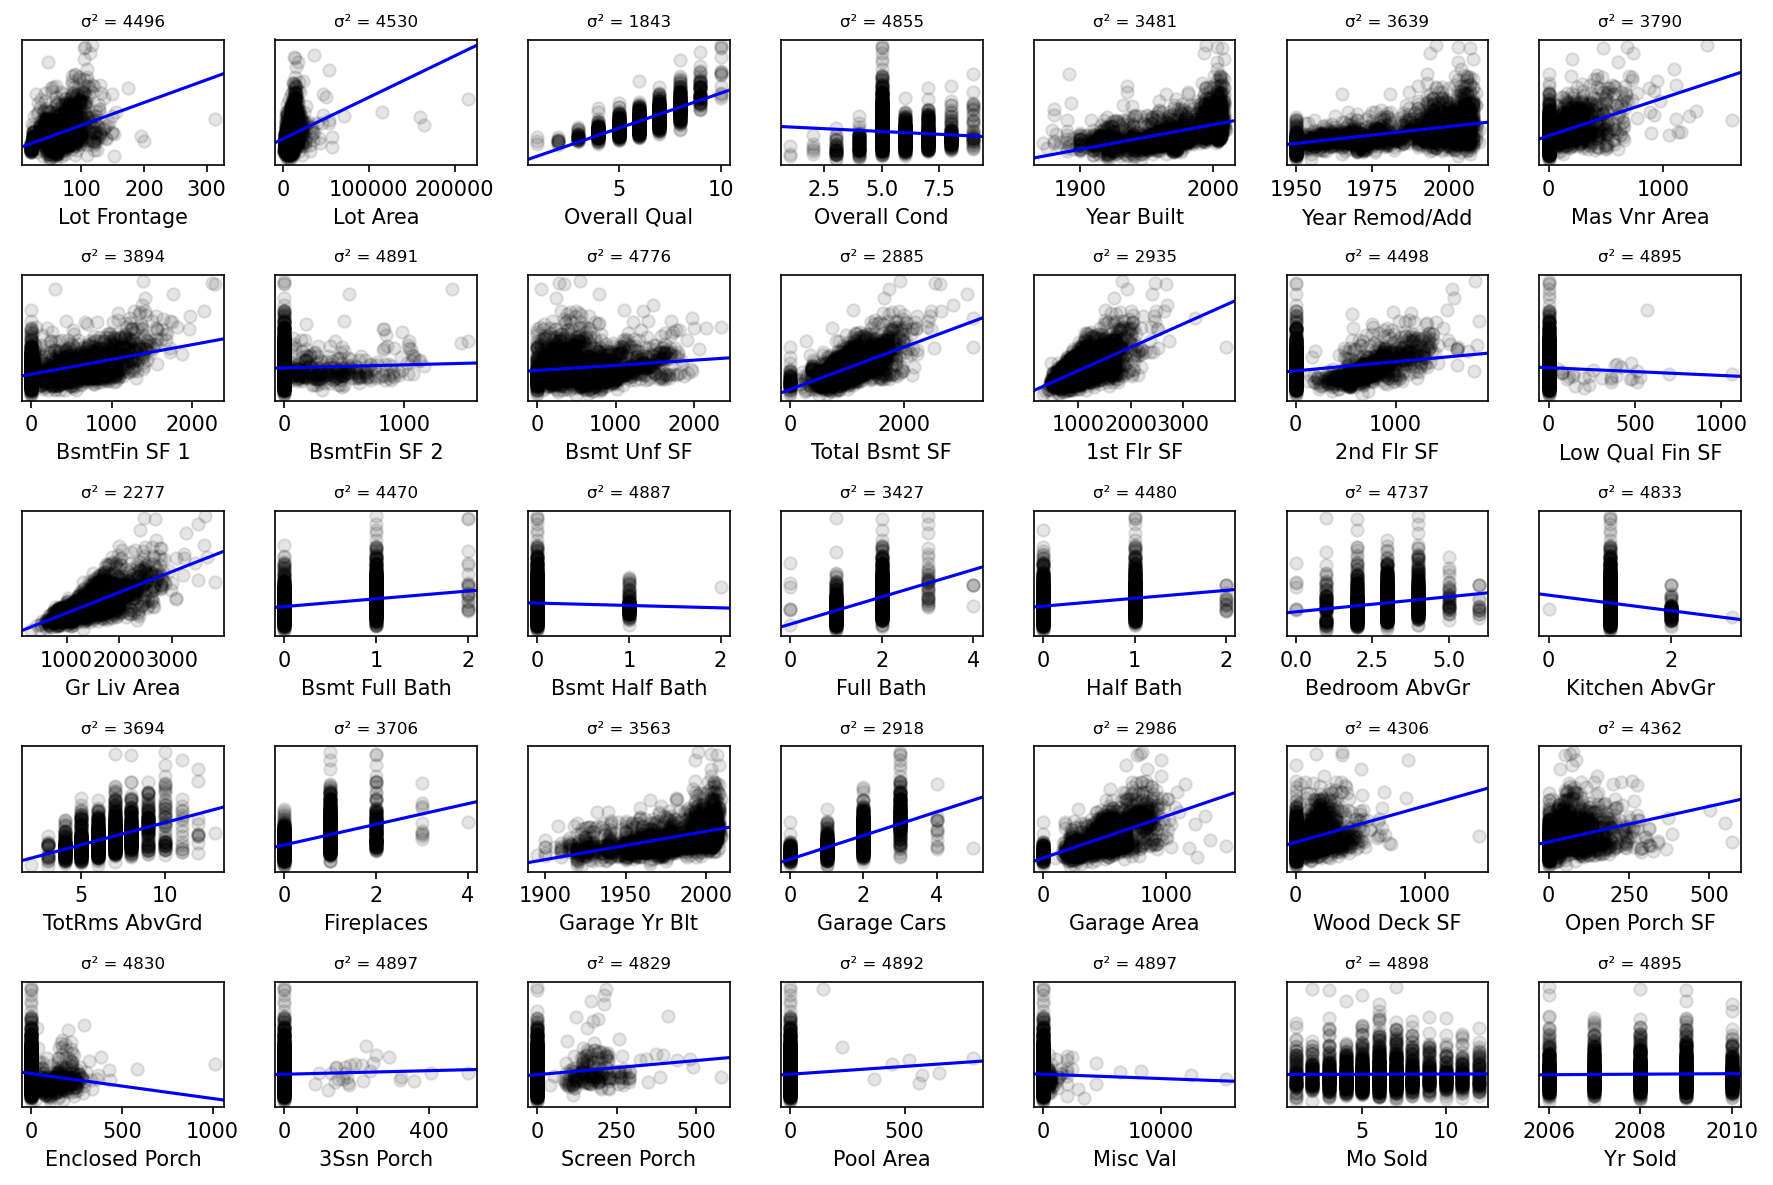

In [130]:
# YOUR ANSWER (CODE) HERE
count = 0
subplots = getsubplots(iscat.count(False)-1)
for j in range(nfeat-1):
    if iscat[j] == False:
        salesprices = X[:,-1]
        col = X[:,j]
        non_NA = np.isnan(col)
        non_na_index = []
        for i in range(len(non_NA)):
            if non_NA[i] == True:
                non_na_index.append(i)
        col = np.delete(col,non_na_index)
        salesprices = np.delete(salesprices,non_na_index)

        subplots[count].set_xlabel(featurenames[j])
        subplots[count].scatter(col,salesprices, color = 'black', alpha=0.1)
        
        q1,q2,q3,d1,d2 = 0,0,0,0,0
        for row in range(len(col)):
            q1 = q1 + col[row]*salesprices[row]
            q2 = q2 + col[row]
            q3 = q3 + salesprices[row]
            d1 = d1 + col[row]*col[row]
            d2 = d2 + col[row]
        a = (q1 - q2*q3/len(col) )/( d1 - d2*d2/len(col) )
        b = ( (d1*q3) - (q2*q1) ) / ( (len(col)*d1) - (d2*d2) )

        sig = 0
        for row in range(len(col)):
            sig = sig + (salesprices[row] - a*col[row] - b)*(salesprices[row] - a*col[row] - b)/len(col)
        subplots[count].set_title("σ² = " + str(int(sig)),  fontsize=8)
        subplots[count].yaxis.set_visible(False)
        plotline(subplots[count],a,b)
        count = count +1
        
plt.gcf().tight_layout()

### Question 3
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 0/2<br>
</div>

Note that in the regression above, there is a negative correlation between the number of kitchens (feature "Kitchen AbvGr") and the selling price.  Does this mean that if I add a kitchen to my home, it will cause it to sell for less money?  Or, that if I have two kitchens removing one before selling will increase the price?

Explain your answer, perhaps with an example if that helps.

In [ ]:
If we assume all other column features are constant or similar then "yes"(to both questions) if we reduce the number of kitchens then the price 
of the house increases. But in real life that isnt the case and there are many features which influence the sales price and
the combination of them might cause the price to increse even if there is a negative corelation for one of them.
For example if the houses with 2 or more kitches are in a bad neighbourhood then the sales price will be lesser than
 houses with a single or no kitchen in a very good neighbourhood, Or increasing kitchens reduces the number of bedrooms thereby decreasing the 
    sales price.

# YOUR ANSWER HERE

### Question 4
#### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2.5/3<br>
</div>

Read on Simpson's paradox in the book.  Let's search to see if this situation is present in this data.

In particular, search (systematically, via code) to see if there is a real-valued feature, $x_1$, with a positive (or negative) correlation with the price.  But, when you condition on a separate discrete-valued feature, $x_2$, the correlation of $x_1$ with the price is non-positive (or non-negative) for every conditioning value of $x_2$.

For any such combination you find, plot $y$ versus the values of $x_1$, with the points colored by the value of $x_2$.  On this plot, plot the regression fit line of $x_1$ as a whole in black and the regression lines for each of the conditioning values (of $x_2$) in colors that match the corresponding scatter points. Label the plot with the names of the features.

Note 1: You will not find any for which the sign reverses for all values of $x_2$, but you will find ones for which the sign reverses for some values of $x_2$ and is $0$ for other values.  Plot those.

Note 2: You should not need to write much more code; you should be able to reuse the plotting and regression code from above.

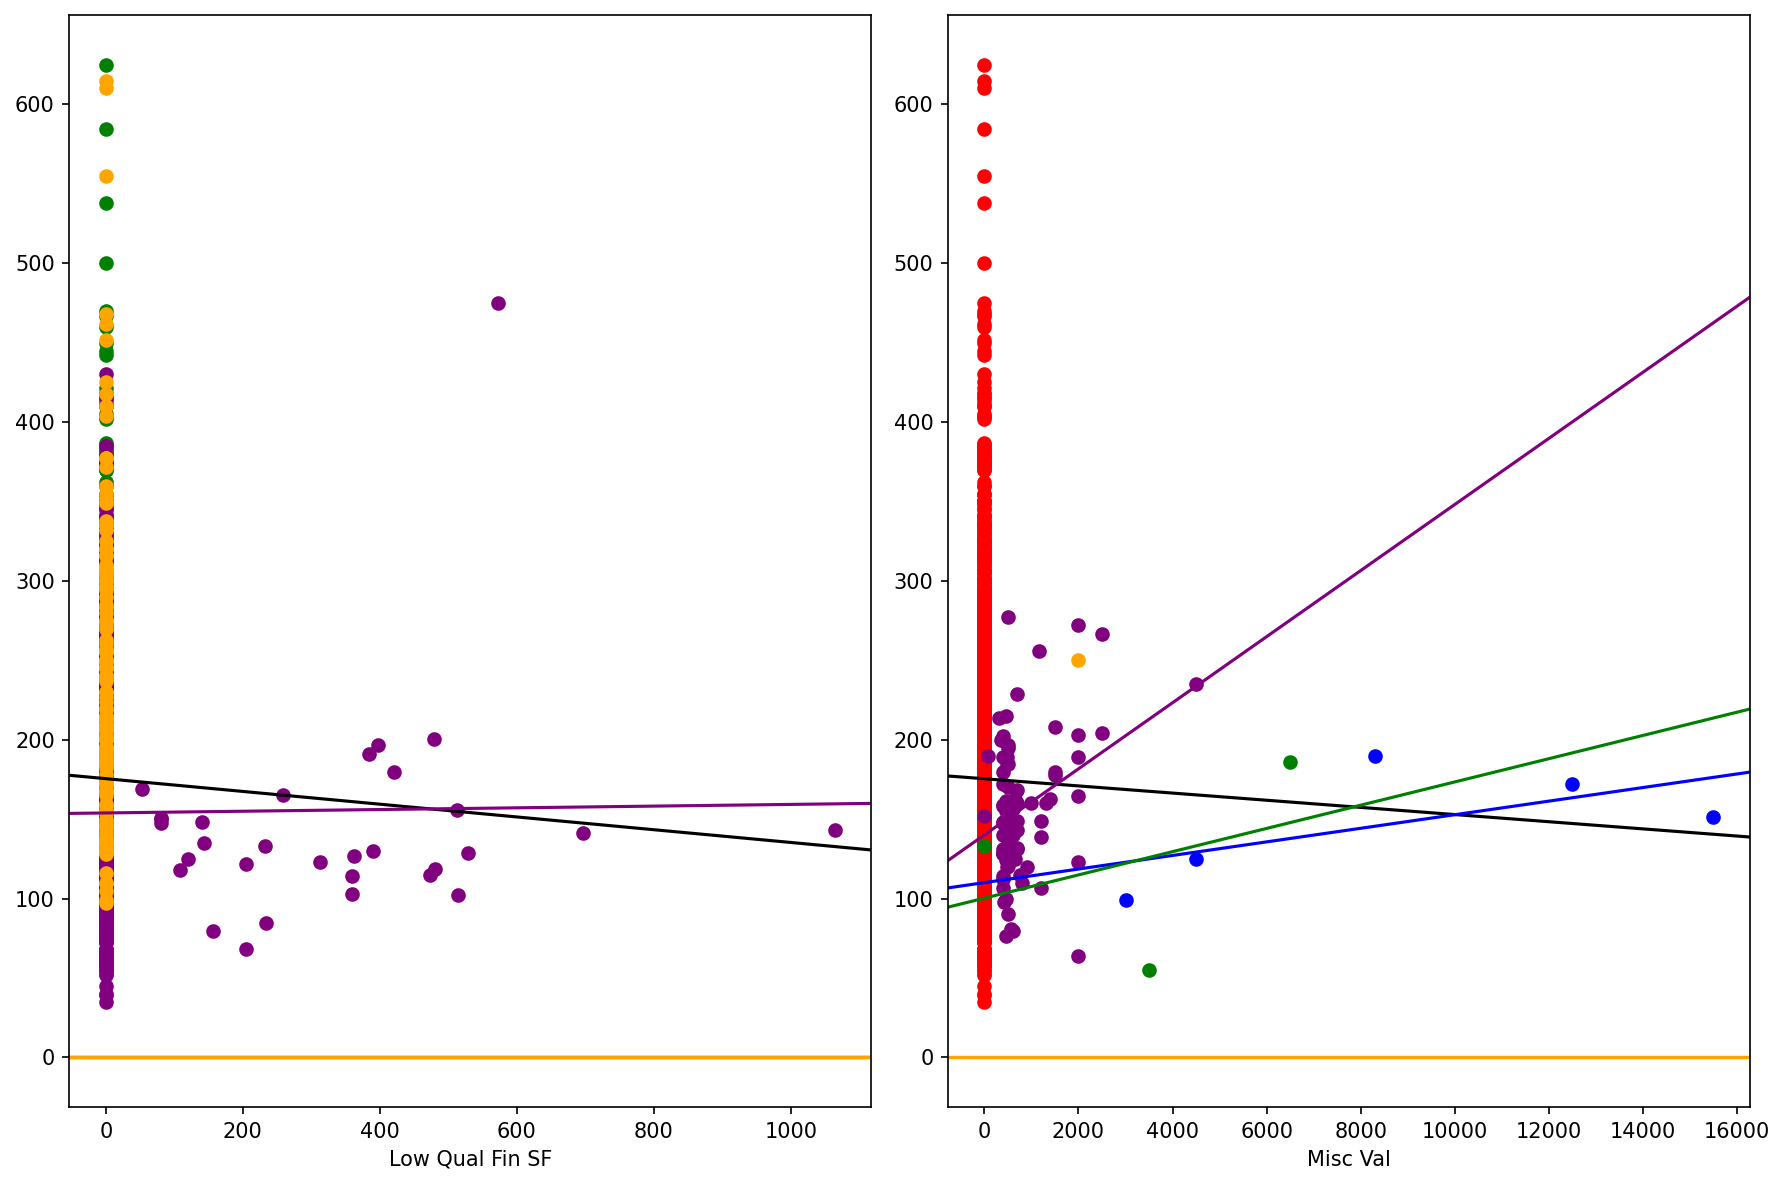

In [132]:
# THIS TAKES AROUND 2 MINUTES TO RUN SINCE ITS SEARCHING THROUGH ALL CONTINOUS COLUMNS WITH ALL FEATURE COLUMNS
# YOUR ANSWER (CODE) HERE
final_list_paradox = []
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 8)

for j1 in range(nfeat-1):
    # if iscat[j1] == False and featurenames[j1] == "Misc Val":
    if iscat[j1] == False:
        for j2 in range(nfeat-1):
            # if iscat[j2] == True and featurenames[j2]=="Misc Feature":
            if iscat[j2] == True:
                salesprices = X[:,-1]
                X1 = X[:,j1]
                X2 = X[:,j2]
                non_NA = np.isnan(X1)
                non_na_index = []
                
                for i in range(len(non_NA)):
                    if non_NA[i] == True:
                        non_na_index.append(i)
                X1 = np.delete(X1,non_na_index)
                X2 = np.delete(X2,non_na_index)
                salesprices = np.delete(salesprices,non_na_index)

                #main line
                q1,q2,q3,d1,d2 = 0,0,0,0,0
                for row in range(len(X1)):
                    q1 = q1 + X1[row]*salesprices[row]
                    q2 = q2 + X1[row]
                    q3 = q3 + salesprices[row]
                    d1 = d1 + X1[row]*X1[row]
                    d2 = d2 + X1[row]
                a = (q1 - q2*q3/len(X1) )/( d1 - d2*d2/len(X1) )
                b = ( (d1*q3) - (q2*q1) ) / ( (len(X1)*d1) - (d2*d2) )
                #[(a,b),(a,b)]
                # subplots[0].scatter(X1,salesprices)
                # plotline(subplots[0],a,b,clr = "black")
                list_of_ab = []
                
                main_a = a
                main_b = b
                if main_a == 0:
                    continue
                
                Q1 = [0]*len(categorynames[j2])
                Q2 = [0]*len(categorynames[j2])
                Q3 = [0]*len(categorynames[j2])
                D1 = [0]*len(categorynames[j2])
                D2 = [0]*len(categorynames[j2])

                kcount = [0]*len(categorynames[j2])
                list_of_points_index = [[] for _ in range(len(categorynames[j2]))]

                for row in range(len(X1)):
                    Q1[int(X2[row])] = Q1[int(X2[row])] + X1[row]*salesprices[row]
                    Q2[int(X2[row])] = Q2[int(X2[row])] + X1[row]
                    Q3[int(X2[row])] = Q3[int(X2[row])] + salesprices[row]
                    D1[int(X2[row])] = D1[int(X2[row])] + X1[row]*X1[row]
                    D2[int(X2[row])] = D2[int(X2[row])] + X1[row]

                    kcount[int(X2[row])] = kcount[int(X2[row])] + 1
                    list_of_points_index[int(X2[row])].append(row)
                
                for index in range(len(categorynames[j2])):
                    if( not kcount[index] or (D1[index] - D2[index]*D2[index]/kcount[index] ) == 0 ):
                        a = 0
                    else:
                        a = (Q1[index] - Q2[index]*Q3[index]/kcount[index] )/( D1[index] - D2[index]*D2[index]/kcount[index] )

                    if(( (kcount[index]*D1[index]) - (D2[index]*D2[index])) == 0):
                        b=0
                    else:
                        b = ( (D1[index]*Q3[index]) - (Q2[index]*Q1[index]) ) / ( (kcount[index]*D1[index]) - (D2[index]*D2[index]) )
                    
                    list_of_ab.append([a,b])
                
                # print(len(categorynames[j2]))
                # print(list_of_ab)
                # for a,b in list_of_ab:
                #     plotline(subplots[0],a,b,clr = "red")
                flag1 = 0
                if(main_a > 0):
                    for a,b in list_of_ab:
                        if(a > 0):
                            flag1 = 1
                            break
                else:
                    for a,b in list_of_ab:
                        if(a < 0):
                            flag1 = 1
                            break
                if flag1 == 0:
                    final_list_paradox.append([j1,main_a,main_b,list_of_ab,list_of_points_index])

                    
                    # print(featurenames[j1],featurenames[j2], main_a , list_of_ab)
                    # for a,b in list_of_ab:
                    #     plotline(subplots[0],a,b,clr = "red")

# print(final_list_paradox)               
subplots = getsubplots(2)  


color_index = ["red","blue","green","purple","orange","yellow"]
for j in range(len(final_list_paradox)):
    j1 = final_list_paradox[j][0]
    list_of_points_index = final_list_paradox[j][4]

    index = 0
    for i in list_of_points_index:
        X1 = []
        Y1 = []
        for i2 in i:
            X1.append(X[i2,j1])
            Y1.append(X[i2,-1])
        subplots[j].scatter(X1,Y1,color=color_index[index%6])
        subplots[j].set_xlabel(featurenames[j1])
        index = index + 1

    plotline(subplots[j],final_list_paradox[j][1],final_list_paradox[j][2], clr="black")
    index= 0
    for a,b in final_list_paradox[j][3]:
        plotline(subplots[j],a,b,clr=color_index[index%6])
        index = index + 1

plt.gcf().tight_layout()